In [1]:
import numpy as np
import pandas as pd
import json

import matplotlib.pyplot as plt
import seaborn as sns

from geopy import distance
from shapely.geometry import Point
import geopandas as gpd
import contextily as ctx
import shapefile as shp

import datetime as dt
import glob

%matplotlib inline

Собрали из 12 месячных файлов 1 за весь 2019 год

In [2]:
bike_data_2019 = glob.glob("/Users/kirillvolkov/Desktop/Habidatum/2019/*.csv") 
bike_data_2019 = pd.concat((pd.read_csv(f, header = 0) for f in bike_data_2019))
##bike_data_2019.to_csv("bike_data_2019.csv")

In [3]:
bike_data_2019.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 404947 entries, 0 to 36134
Data columns (total 15 columns):
tripduration               404947 non-null int64
starttime                  404947 non-null object
stoptime                   404947 non-null object
start station id           404947 non-null int64
start station name         404947 non-null object
start station latitude     404947 non-null float64
start station longitude    404947 non-null float64
end station id             404947 non-null int64
end station name           404947 non-null object
end station latitude       404947 non-null float64
end station longitude      404947 non-null float64
bikeid                     404947 non-null int64
usertype                   404947 non-null object
birth year                 404947 non-null int64
gender                     404947 non-null int64
dtypes: float64(4), int64(6), object(5)
memory usage: 49.4+ MB


In [4]:
bike_data_2019['tripduration_min'] = round(bike_data_2019['tripduration'] / 60, 1)
bike_data_2019['Month'] = pd.to_datetime(bike_data_2019['starttime']).dt.month
bike_data_2019['Hour'] = pd.to_datetime(bike_data_2019['starttime']).dt.hour
bike_data_2019['Weekday'] = pd.to_datetime(bike_data_2019['starttime']).dt.day_name()

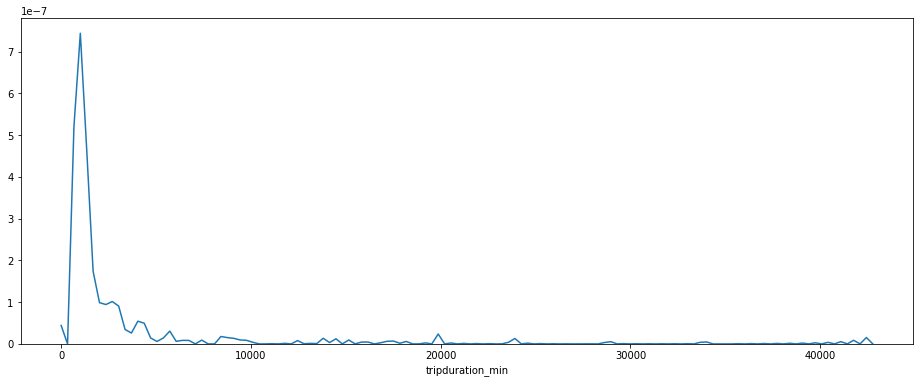

In [5]:
#в начале данные о времени поездки распределены нормально, а в конце присутствует ряд аномалных значений
fig, ax = plt.subplots(1, 1, figsize=(16, 6))
sns.distplot(bike_data_2019['tripduration_min'], hist=False)

Для очистки данных хотел отсеять все данные больше чем (75 квартиль + 1.5*интерквартильный размах), но так как Q3 = 9.7 минут, то получилось что мы отсеем много правдоподобных данных, поэтому удалим все поездки больше 12 часов = 720 минут.

In [6]:
bike_data_2019 = bike_data_2019[(bike_data_2019['tripduration_min'] < 720)]

In [7]:
bike_data_2019.describe()

,tripduration,start station id,start station latitude,start station longitude,end station id,end station latitude,end station longitude,bikeid,birth year,gender,tripduration_min,Month,Hour
count,404597.000000,404597.000000,404597.000000,404597.000000,404597.000000,404597.000000,404597.000000,404597.000000,404597.000000,404597.000000,404597.000000,404597.000000,404597.000000
mean,577.743191,3294.007469,40.722721,-74.046332,3292.248739,40.722327,-74.045791,28465.656070,1981.420549,1.162737,9.629003,6.950106,13.605044
std,1068.189487,170.999260,0.007035,0.010870,180.486259,0.006879,0.010823,1654.433222,10.256301,0.515678,17.803202,2.999511,5.085058
min,61.000000,3183.000000,40.709651,-74.083639,116.000000,40.701403,-74.083639,14792.000000,1887.000000,0.000000,1.000000,1.000000,0.000000
25%,233.000000,3195.000000,40.718355,-74.050444,3192.000000,40.718355,-74.050389,26286.000000,1975.000000,1.000000,3.900000,5.000000,9.000000
50%,345.000000,3210.000000,40.721525,-74.043845,3207.000000,40.721124,-74.043117,29284.000000,1984.000000,1.000000,5.800000,7.000000,14.000000
75%,579.000000,3276.000000,40.727224,-74.038051,3276.000000,40.727224,-74.038051,29536.000000,1989.000000,1.000000,9.600000,9.000000,18.000000
max,43186.000000,3792.000000,40.748716,-74.032108,3792.000000,40.814326,-73.932077,41913.000000,2003.000000,2.000000,719.800000,12.000000,23.000000


In [8]:
# Create a "Route ID" in the "[start station id]-[end station id]" format
bike_data_2019['Route Id'] = bike_data_2019.apply(lambda x: '{0}-{1}'.format(int(x['start station id']), int(x['end station id'])), axis=1)

In [9]:
# Extract the unique routes from the data with their start and end coordinates
maps = bike_data_2019[['Route Id', 'start station id', 'start station latitude', 'start station longitude', 'end station id', 'end station latitude', 'end station longitude']].drop_duplicates()
maps['Distance'] = maps.apply(lambda x: distance.distance((x['start station latitude'], x['start station longitude']), (x['end station latitude'], x['end station longitude'])).km * 1000, axis=1)

In [10]:
# Merge the distance calculation with the main DataFrame
bike_data_2019 = bike_data_2019.merge(maps[['Route Id', 'Distance']], how='left', on='Route Id')
bike_data_2019 = bike_data_2019[[x for x in bike_data_2019.columns if not 'From' in x and not 'To' in x and x != 'Route Id']]

No handles with labels found to put in legend.


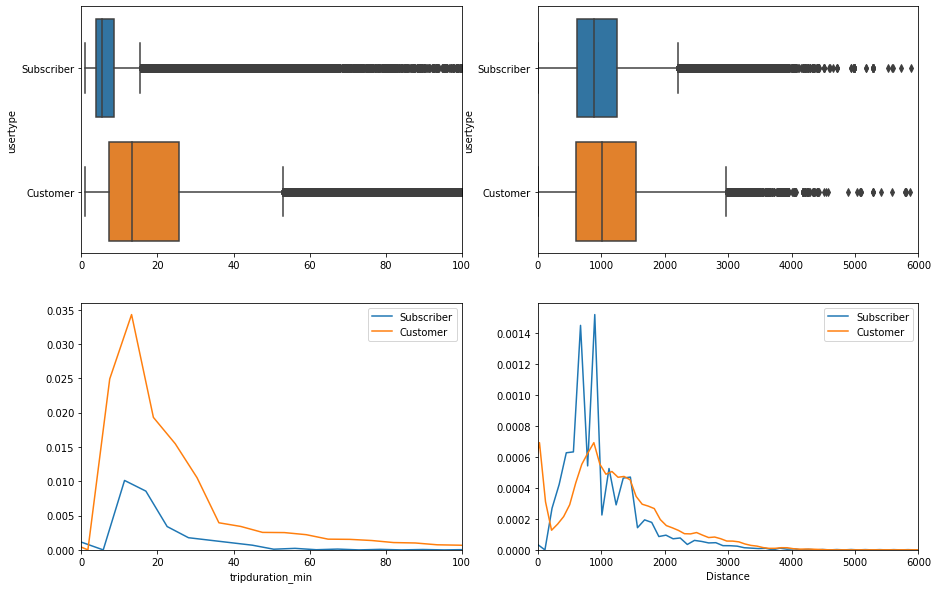

In [207]:
fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(15, 10))
for i, col in enumerate(['tripduration_min', 'Distance']):
    for j, user in enumerate(bike_data_2019['usertype'].unique()):
        sns.distplot(bike_data_2019[bike_data_2019['usertype']==user][col], hist=False, ax=ax2[i], label = user)
    plt.legend()
    
    # Graph the boxplots
    sns.boxplot(x=col, y='usertype', data=bike_data_2019, ax=ax1[i])
    ax1[i].set_xlabel('')

ax1[1].set(xlim=(0,6000))
ax2[1].set(xlim=(0,6000))

ax1[0].set(xlim=(0,100))
ax2[0].set(xlim=(0,100))

#saving our graph as .png file.
#fig.savefig('Density.png', dpi=300)

Text(0, 0.5, 'number of rides')

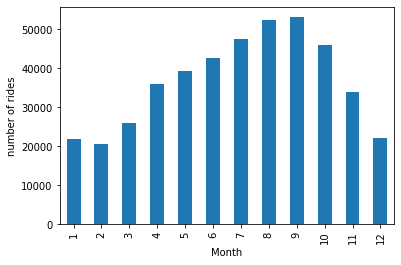

In [213]:
bike_data_2019.groupby(['Month']).count()['tripduration'].plot(kind = 'bar')
plt.ylabel('number of rides')

**Частота использования станций на карте**

In [13]:
gdf=gpd.GeoDataFrame(bike_data_2019, crs={'init' :'epsg:4326'}, geometry=gpd.points_from_xy(bike_data_2019['start station longitude'], bike_data_2019['start station latitude']))

In [14]:
station_popularaty = pd.DataFrame(gdf['start station id'].value_counts().reset_index())
gdf['station_count']= gdf['start station id'].map(gdf['start station id'].value_counts())

In [15]:
bike_lanes = gpd.read_file('/Users/kirillvolkov/Desktop/Habidatum/bike infrastructure/bake lines.geojson')
protected_bike_lanes = gpd.read_file('/Users/kirillvolkov/Desktop/Habidatum/bike infrastructure/protected_bike_lanes.geojson')
bike_lanes = bike_lanes.to_crs(epsg=3857)
protected_bike_lanes = protected_bike_lanes.to_crs(epsg=3857)
                           

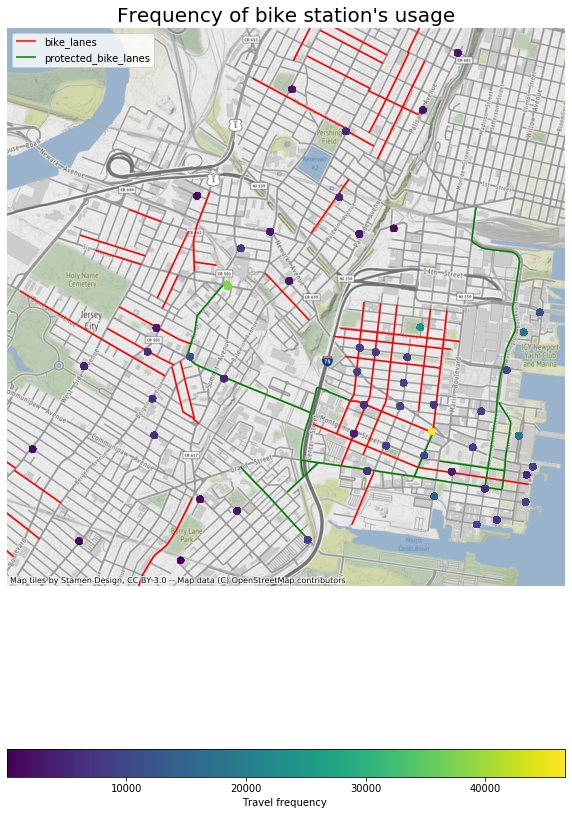

In [16]:
gdf = gdf.to_crs(epsg=3857)
ax = gdf.plot(column='station_count', figsize=(10, 20), legend=True, zorder=3, 
              legend_kwds={'label': "Travel frequency ",'orientation': "horizontal"})
ctx.add_basemap(ax)
bike_lanes.plot(ax=ax, color='red', label = 'bike_lanes',zorder=1)
protected_bike_lanes.plot(ax=ax, color='green', label = 'protected_bike_lanes', zorder=2)
_ = ax.set_title("Frequency of bike station's usage", fontdict={'fontsize': '20', 'fontweight' : '3'} )
ax.axis('off')
plt.legend()
plt.show()

#saving our map as .png file.
#fig.savefig(‘Usage_frequency.png’, dpi=300)

**Районы города**

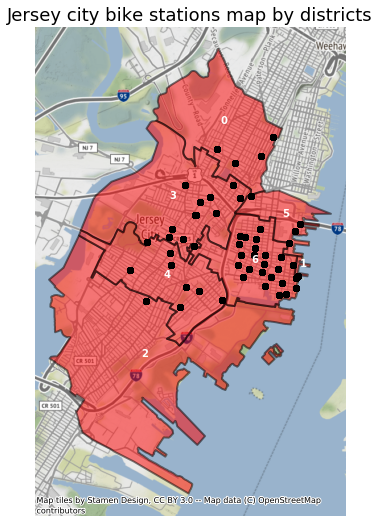

<Figure size 432x288 with 0 Axes>

In [197]:
jersey=gpd.read_file('/Users/kirillvolkov/Desktop/Habidatum/jersey-city-zipcode-map.geojson')
jersey = jersey.to_crs(epsg=3857)
ax = jersey.plot(figsize=(11, 9), alpha=0.5, color='red',edgecolor='black', linewidth=2, zorder=1)
ctx.add_basemap(ax)
gdf = gdf.to_crs(epsg=3857)
gdf.plot(ax=ax, color='black', zorder=2)
_ = ax.set_title('Jersey city bike stations map by districts', fontdict={'fontsize': '18', 'fontweight' : '2'})

for i, geo in jersey.centroid.iteritems():
    ax.annotate(s=i, xy=[geo.x, geo.y], color="white", fontweight='bold')

ax.axis('off')
plt.show()

#saving our map as .png file.
#fig.savefig('stations_map.png', dpi=300)

In [18]:
pop = jersey[['zcta5ce10', 'geometry']]
gdf = gpd.sjoin(gdf, pop, how="inner", op="within")
gdf

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,...,gender,tripduration_min,Month,Hour,Weekday,Distance,geometry,station_count,index_right,zcta5ce10
0,142,2019-02-01 15:35:02.0820,2019-02-01 15:37:24.1360,3183,Exchange Place,40.716247,-74.033459,3639,Harborside,40.719252,...,1,2.4,2,15,Friday,340.046171,POINT (-8241366.935 4970577.810),5313,6,07302
1,223,2019-02-01 17:00:46.8900,2019-02-01 17:04:30.5500,3183,Exchange Place,40.716247,-74.033459,3681,Grand St,40.715178,...,2,3.7,2,17,Friday,376.182448,POINT (-8241366.935 4970577.810),5313,6,07302
2,106,2019-02-01 17:08:01.3260,2019-02-01 17:09:47.4400,3183,Exchange Place,40.716247,-74.033459,3184,Paulus Hook,40.714145,...,1,1.8,2,17,Friday,233.500777,POINT (-8241366.935 4970577.810),5313,6,07302
3,370,2019-02-01 17:09:31.2100,2019-02-01 17:15:41.6550,3183,Exchange Place,40.716247,-74.033459,3211,Newark Ave,40.721525,...,1,6.2,2,17,Friday,1233.516755,POINT (-8241366.935 4970577.810),5313,6,07302
4,315,2019-02-01 17:19:53.2490,2019-02-01 17:25:09.1400,3183,Exchange Place,40.716247,-74.033459,3273,Manila & 1st,40.721651,...,1,5.2,2,17,Friday,997.141835,POINT (-8241366.935 4970577.810),5313,6,07302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438818,637,2019-05-30 14:06:14.1750,2019-05-30 14:16:51.2750,3694,Jackson Square,40.711130,-74.078900,3679,Bergen Ave,40.722104,...,1,10.6,5,14,Thursday,1371.407098,POINT (-8246425.427 4969826.323),995,2,07305
439193,1862,2019-05-31 04:45:40.5700,2019-05-31 05:16:42.9370,3694,Jackson Square,40.711130,-74.078900,3694,Jackson Square,40.711130,...,0,31.0,5,4,Friday,0.000000,POINT (-8246425.427 4969826.323),995,2,07305
439243,918,2019-05-31 06:20:05.5670,2019-05-31 06:35:23.9800,3694,Jackson Square,40.711130,-74.078900,3184,Paulus Hook,40.714145,...,1,15.3,5,6,Friday,3846.496306,POINT (-8246425.427 4969826.323),995,2,07305
439454,1633,2019-05-31 08:23:47.5820,2019-05-31 08:51:01.4400,3694,Jackson Square,40.711130,-74.078900,3199,Newport Pkwy,40.728745,...,2,27.2,5,8,Friday,4410.907960,POINT (-8246425.427 4969826.323),995,2,07305


In [19]:
gdf.rename(columns={'index_right':'district'}, inplace=True)

count number of bike's rentals by district

In [89]:
bike_points = {}
for i in range(len(jersey)):
    pip_mask = gdf.within(jersey.loc[i, 'geometry'])
    pip_data = gdf.loc[pip_mask]['start station id'].nunique()
    bike_points[i] = pip_data

In [120]:
bike_points = pd.DataFrame.from_dict(bike_points, orient='index')
bike_points

TypeError: 'numpy.ndarray' object is not callable

Bike rental's usage (frequency)

In [127]:
rentals_usage = gdf.groupby(['district']).count()['tripduration'] / bike_points[0]

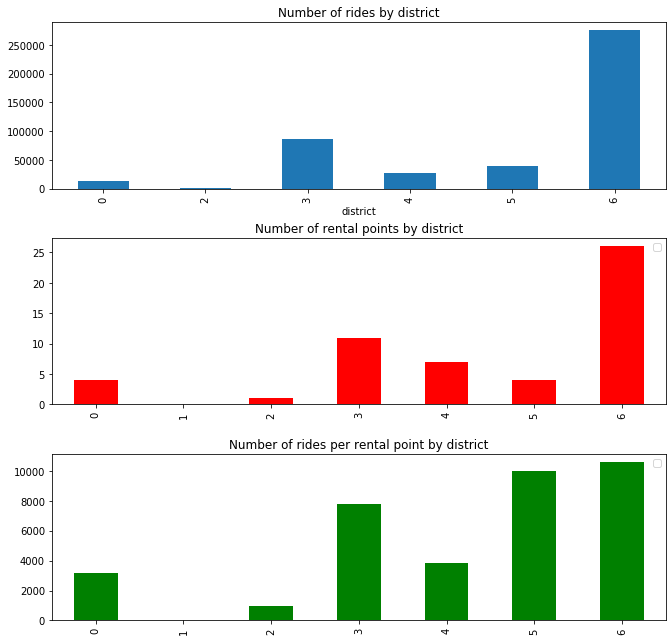

In [142]:
fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize=(11,11))
ax1, ax2, ax3  = ax.flatten()

gdf.groupby(['district']).count()['tripduration'].plot(kind = 'bar', ax=ax1)
ax1.set_title("Number of rides by district")


bike_points.plot(kind = 'bar', ax=ax2, color = 'red')
ax2.set_title("Number of rental points by district")
ax2.legend('')

rentals_usage.plot(kind = 'bar', ax=ax3, color = 'green')
ax3.set_title("Number of rides per rental point by district")
ax3.legend('')


plt.subplots_adjust(hspace = 0.3)
plt.show()

На графике который показывает среднее пройденное расстояние, мы видим, примерно одинаковое распределение между Покупателями и Подписчиками, но при этом очень сильное различие по времени использования, что может говорить a) об использьвании велосипеда Покупателями для целях отдыха и неторопливой поездки, b) о том что им тяжелее разобраться с инфрострукторой и найти нужную станцию для финиша.

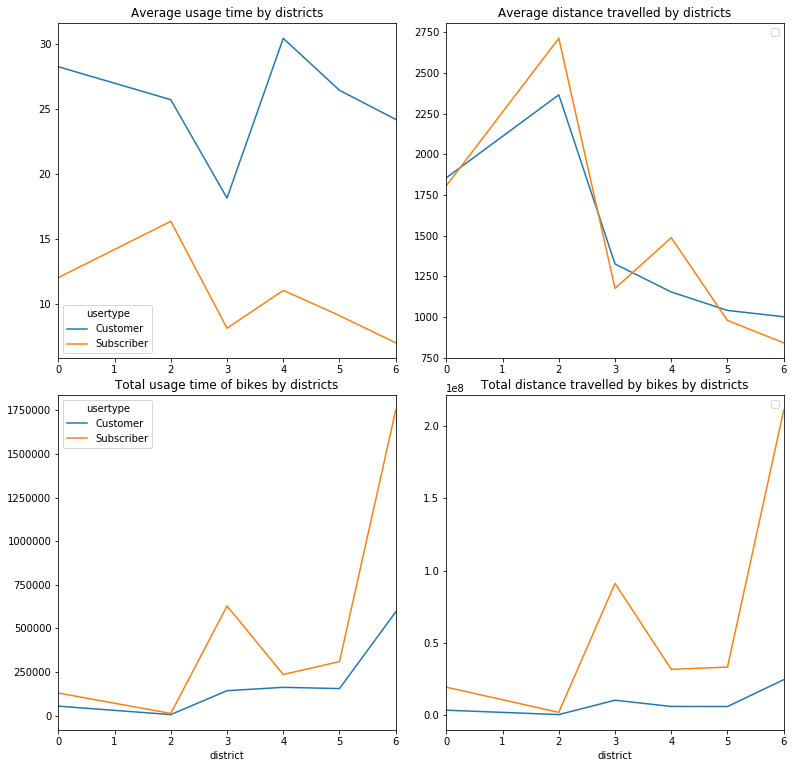

In [215]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize=(13,13))
ax1, ax2, ax3, ax4 = ax.flatten()

gdf.groupby(['district', 'usertype',]).mean()['tripduration_min'].unstack().plot(ax=ax1)
gdf.groupby(['district', 'usertype',]).mean()['Distance'].unstack().plot(ax=ax2)
gdf.groupby(['district', 'usertype',]).sum()['tripduration_min'].unstack().plot(ax=ax3)
gdf.groupby(['district', 'usertype',]).sum()['Distance'].unstack().plot(ax=ax4)

ax1.set_title("Average usage time by districts", fontdict={'fontsize': '12', 'fontweight' : '5'})
ax1.set_xlabel('')
ax2.set_title("Average distance travelled by districts", fontdict={'fontsize': '12', 'fontweight' : '5'})
ax2.set_xlabel('')
ax2.legend('')
ax3.set_title("Total usage time of bikes by districts", fontdict={'fontsize': '12', 'fontweight' : '5'})
ax4.set_title("Total distance travelled by bikes by districts", fontdict={'fontsize': '12', 'fontweight' : '5'})
ax4.legend('')

plt.subplots_adjust(hspace = 0.11, wspace = 0.15)
#fig.savefig('usage_time_distance.png', dpi=300)

**Обращаем внимание на поездки с нулевым пробегом, то есть велосипед взяли и вернули на одну станцию. 
Можно предположить, что это поездки, совершенные с рекреационными целями**

In [27]:
total_time_0 = gdf[gdf['Distance'] == 0]['tripduration_min'].sum()
total_time = gdf['tripduration_min'].sum()
share_0 = total_time_0/total_time
time_share_0

0.14268525922043815

In [28]:
total_time_0 = gdf[gdf['Distance'] == 0]['tripduration_min'].count()
total_time = gdf['tripduration_min'].count()
sharebycount_0 = total_time_0/total_time
sharebycount_0

0.040063353467876255

Интересно, что данные поездки состовляют всего 4% от общей массы по кол-ву, но при этом по общему времени поездок они составляют 14%. При этом кол-во поездок и их среднее время сильно растет в субботу и воскресенье, по трем наиболее активным районам (4,5,6). Но над отметить, что среднее время поездки в выходные больше, чем в будни практически во всех районах (0, 3, 4, 5, 6), при этом в районе (1,4) самое длинное время поездки в понедельник и четверг.

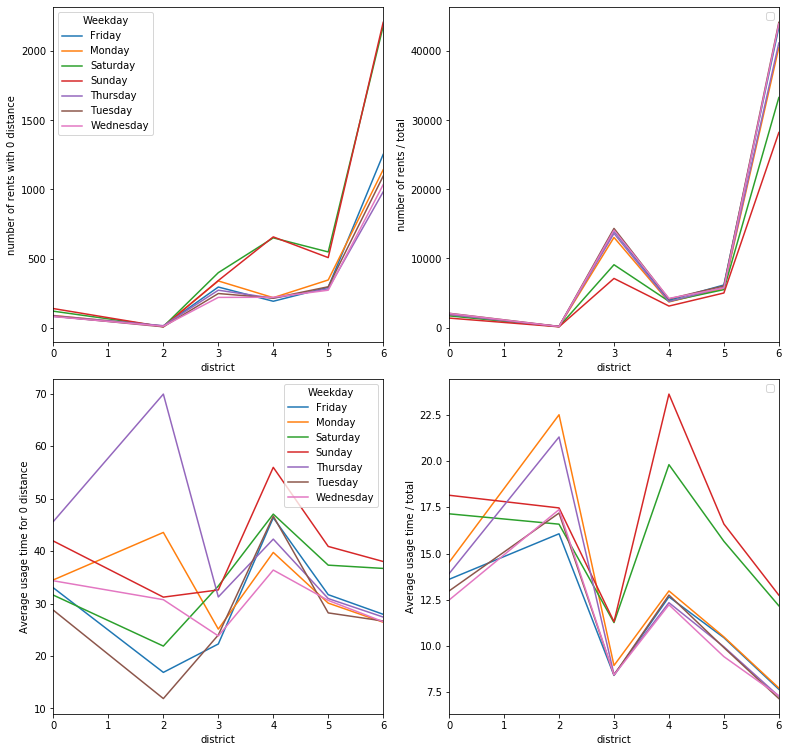

In [216]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize=(13,13))
ax1, ax2, ax3, ax4 = ax.flatten()

gdf[gdf['Distance'] == 0].groupby(['district','Weekday']).count()['tripduration_min'].unstack().plot(ax=ax1)
ax1.set_ylabel('number of rents with 0 distance')

gdf.groupby(['district','Weekday']).count()['tripduration_min'].unstack().plot(ax=ax2)
ax2.set_ylabel('number of rents / total')
ax2.legend('')

gdf[gdf['Distance'] == 0].groupby(['district','Weekday']).mean()['tripduration_min'].unstack().plot(ax=ax3)
ax3.set_ylabel('Average usage time for 0 distance')

gdf.groupby(['district','Weekday']).mean()['tripduration_min'].unstack().plot(ax=ax4)
ax4.set_ylabel('Average usage time / total')
ax4.legend('')

plt.subplots_adjust(hspace = 0.11)
#fig.savefig('usage_by_weekdays.png', dpi=300)

**Common customer by sex and district**

In [187]:
lst = [1,2]
common_customer_time = gdf[gdf['gender'].isin(lst)].groupby(['district', 'gender','birth year']).agg(max_duration=('tripduration_min', 'sum'))
common_customer_rides = gdf[gdf['gender'].isin(lst)].groupby(['district', 'gender','birth year']).agg(max_rides=('tripduration_min', 'count')) 

In [189]:
common_customer_time[common_customer_time['max_duration'] == common_customer_time.groupby(['district','gender'])['max_duration'].transform('max')]

max_duration
district gender birth year              
0        1      1991              9302.4
         2      1989              4602.7
2        1      1988              3052.1
         2      1991              1474.8
3        1      1988             36546.5
         2      1990             13231.4
4        1      1988             19314.0
         2      1986              6964.5
5        1      1988             17009.3
         2      1989              8073.9
6        1      1989             87152.1
         2      1989             38661.7

In [191]:
common_customer_rides[common_customer_rides['max_rides'] == common_customer_rides.groupby(['district','gender'])['max_rides'].transform('max')]

max_rides
district gender birth year           
0        1      1991              890
         2      1995              316
2        1      1988              194
         2      1991               82
3        1      1988             3674
         2      1990             1597
4        1      1988             1620
         2      1986              566
5        1      1988             1886
         2      1989              735
6        1      1989            11503
         2      1988             4284